<a href="https://colab.research.google.com/github/hoboroots/masked_face_classification/blob/gh-pages/masked_face_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install apache-beam[gcp]
import apache_beam as beam

# OpenCV
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: termcolor, keras-preprocessing, numpy, scipy, absl-py, protobuf, wrapt, google-pasta, tensorboard, grpcio, gast, six, wheel, tensorflow-estimator, astunparse, h5py, opt-einsum
Required-by: fancyimpute


In [ ]:
import os
import zipfile
import random
import imutils 
import numpy as np 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf

from tensorflow.keras import layers 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.layers import AveragePooling2D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelBinarizer

from imutils import paths 
from shutil import copyfile
from os import getcwd 
from google.colab import drive 
from google.colab import files 


# Accessing My Google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Print the Number of Images in the dataset
print(len(os.listdir('/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/masked')))
print(len(os.listdir('/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/unmasked')))

682
679


In [ ]:
# Get the dataset 
# Dataset source :  
# Create subdirectories training and validation for masked and unmasked images under the datasetmfr 
create_dir = [
    '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/training',
    '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation',
    '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/training/masked',
    '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/training/unmasked',
    '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation/masked',
    '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation/unmasked'
]

for directory in create_dir:
    try:
        os.mkdir(directory) 
        print(directory, 'directory has been created')
    except OSError:
        pass

In [ ]:
# Split data into Training and Validation set

def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    # set array for all image files
    files = []
    # looping file in source directory 
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name
        # check size of the file 
        if os.path.getsize(file_path):
            files.append(file_name) 
        else:
            print('zero length for {}'.format(file_name))
    
    length_files = len(files)
    split_files = int(length_files * SPLIT_SIZE) 
    randomized = random.sample(files, length_files) 
    train_dataset = randomized[:split_files]
    val_dataset = randomized[split_files:]
    
    for file_name in train_dataset:
        copyfile(SOURCE + file_name, TRAINING + file_name)
    
    for file_name in val_dataset:
        copyfile(SOURCE + file_name, VALIDATION + file_name)

# Define source directories
MASKED_SOURCE_DIR = "/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/masked/"
TRAINING_MASKED_DIR = "/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/training/masked/"
VALIDATION_MASKED_DIR = "/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation/masked/"
UNMASKED_SOURCE_DIR = "/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/unmasked/"
TRAINING_UNMASKED_DIR = "/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/training/unmasked/"
VALIDATION_UNMASKED_DIR = "/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation/unmasked/"

# Define the split size: 80% for training, 20% for validation
split_size = .8
split_data(MASKED_SOURCE_DIR, TRAINING_MASKED_DIR, VALIDATION_MASKED_DIR, split_size)
split_data(UNMASKED_SOURCE_DIR, TRAINING_UNMASKED_DIR, VALIDATION_UNMASKED_DIR, split_size)

In [ ]:
# Path directory
base_dir = '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr'

train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

# Directory with our training masked or unmasked pictures
train_masked_dir = os.path.join(train_dir, 'masked')
train_unmasked_dir = os.path.join(train_dir, 'unmasked')

# Directory with our validation masked or unmasked pictures
val_masked_dir = os.path.join(val_dir, 'masked')
val_unmasked_dir = os.path.join(val_dir, 'unmasked')

In [ ]:
# Print the Number of Images for masked or unmasked in the training and testing directories:
print('total training masked images :', len(os.listdir( train_masked_dir ) ))
print('total training unmasked images :', len(os.listdir( train_unmasked_dir ) ))

print('total validation masked images :', len(os.listdir( val_masked_dir ) ))
print('total validation unmasked images :', len(os.listdir( val_unmasked_dir ) ))
print('')

# List some of the Images Name
train_masked_fnames = os.listdir( train_masked_dir )
train_unmasked_fnames = os.listdir( train_unmasked_dir )

print(train_masked_fnames[:10])
print(train_unmasked_fnames[:10])

total training masked images : 545
total training unmasked images : 543
total validation masked images : 137
total validation unmasked images : 136

['augmented_image_60.jpg', 'augmented_image_109.jpg', 'augmented_image_51.jpg', '103-with-mask.jpg', '136-with-mask.jpg', 'augmented_image_71.jpg', '408-with-mask.jpg', 'augmented_image_280.jpg', 'augmented_image_62.jpg', 'augmented_image_55.jpg']
['augmented_image_156.jpg', 'augmented_image_117.jpg', '204.jpg', '16.jpg', '36.jpg', 'augmented_image_180.jpg', 'augmented_image_59.jpg', '104.jpg', 'augmented_image_90.jpg', '180.jpg']


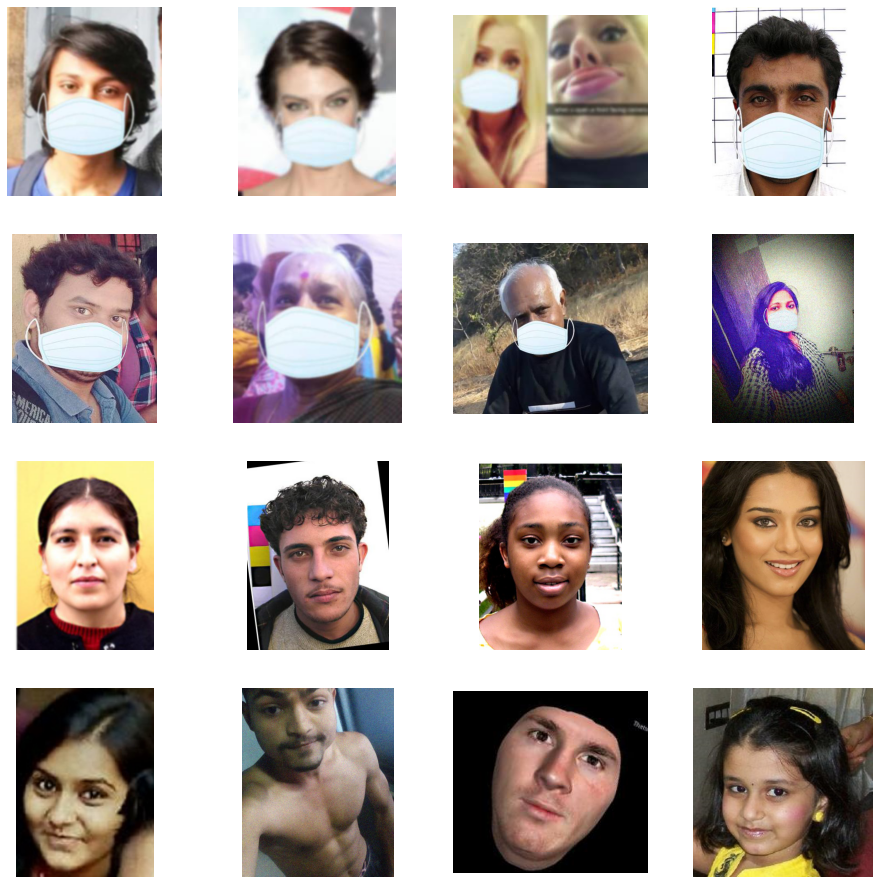

In [ ]:
# List some of the Images

# Parameters for graph; this will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0 

# Set up matplotlib fig, and size it to fit 4x4 pics
# Display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time.

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_masked_pix = [os.path.join(train_masked_dir, fname) 
                for fname in train_masked_fnames[ pic_index-8:pic_index] 
               ]

next_unmasked_pix = [os.path.join(train_unmasked_dir, fname) 
                for fname in train_unmasked_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_masked_pix+next_unmasked_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# Baseline Model using Basic CNN (3 Convolutions and 3 Pooling) with augmentation

model_base = tf.keras.models.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', \
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_base.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 53, 53, 64)        8256      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 43264)            

In [ ]:
# Data Pre-processing using ImageDataGenerator
# Without Data Augmentation

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') 

# validation not be augmented, only rescale.
val_datagen = ImageDataGenerator(rescale=1.0/255) 

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(224, 224)
)

# Flow validation images in batches of 10 using train_datagen generator 
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(224, 224)
)

Found 1088 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


In [ ]:
# Training Baseline Model

history_base = model_base.fit(train_generator,
                              steps_per_epoch = 20,
                              epochs = 20,
                              validation_steps = 20,
                              verbose=1,
                              validation_data = val_generator)

Epoch 1/20
20/20 [==============================] - 16s 806ms/step - loss: 1.2139 - accuracy: 0.5300 - val_loss: 0.6448 - val_accuracy: 0.7600
Epoch 2/20
20/20 [==============================] - 16s 805ms/step - loss: 0.6166 - accuracy: 0.6750 - val_loss: 0.5213 - val_accuracy: 0.6950
Epoch 3/20
20/20 [==============================] - 16s 809ms/step - loss: 0.5771 - accuracy: 0.7273 - val_loss: 0.3039 - val_accuracy: 0.9500
Epoch 4/20
20/20 [==============================] - 16s 820ms/step - loss: 0.3826 - accuracy: 0.8350 - val_loss: 0.2486 - val_accuracy: 0.9100
Epoch 5/20
20/20 [==============================] - 16s 793ms/step - loss: 0.3490 - accuracy: 0.8889 - val_loss: 0.1079 - val_accuracy: 0.9750
Epoch 6/20
20/20 [==============================] - 16s 805ms/step - loss: 0.2398 - accuracy: 0.9150 - val_loss: 0.1771 - val_accuracy: 0.9450
Epoch 7/20
20/20 [==============================] - 16s 811ms/step - loss: 0.2973 - accuracy: 0.8900 - val_loss: 0.0800 - val_accuracy: 0.9800

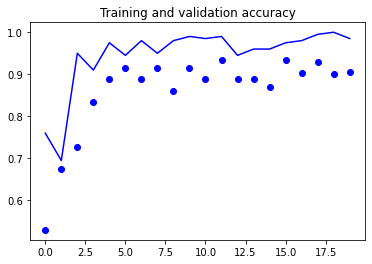

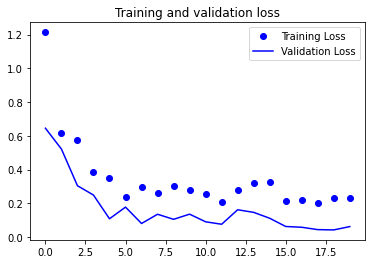

In [ ]:
# Loss and Accuracy Visualization 

acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']
loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Run test on Test Images Dataset
# We collected Test Images Dataset manually using Google Images
# Test Images Dataset consist of 150 unmasked images and 100 masked images

# Files for testing: https://drive.google.com/drive/folders/1erSza7TlApxdMJoM67qIfSJ5bheerBxf?usp=sharing
test_images = '/content//drive/My Drive/Test Images Final Project/masked'
#test_images = '/content//drive/My Drive/Test Images Final Project/unmasked'

# Test Images Edited, Centered : https://drive.google.com/file/d/1sQoxVUmCXWbIfZQT-lkCVNqMIDJH69Dr/view?usp=sharing
    #test_images = '/content//drive/My Drive/Test Images Centered/masked'
    #test_images = '/content//drive/My Drive/Test Images Centered/unmasked'

# Check on validation set
    #test_images = '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation/masked/'
    #test_images = '/content/drive/My Drive/Classroom/BangkitAssignments/Final/datasetmfr/validation/unmasked/'

count_masked = 0
count_unmasked = 0

for fn in os.listdir(test_images) :  
  # predicting images
  path = os.path.join(test_images, fn)
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = x/255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_base.predict(images, batch_size=10)
  if classes[0]>0.5:
    count_unmasked+=1
    #print(fn,"is not masked")
  else:
    count_masked+=1
    #print(fn,"is masked")

totalz = count_masked + count_unmasked
print("")

# Accuracy on Test Images Dataset manually collected from Google
print("{:.3f}".format( (count_masked/totalz*100) ), "percentage classified as masked")
print("{:.3f}".format( (count_unmasked/totalz*100) ), "percentage classified as not masked")


15.333 percentage classified as masked
84.667 percentage classified as not masked


In [ ]:
# 8 june 2020
# Improvement using pre-trained-model MobileNetV2 and Augmentation
# Model: "mobilenetv2_1.00_224" 
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in pre_trained_model.layers:
  layer.trainable = False

# check layers from pre_trained_model 
#pre_trained_model.summary()
# check summary result, note: block_7_add layer 

last_layer = pre_trained_model.get_layer('block_7_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output 

9412608/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 14, 14, 64)


In [ ]:
# Compile model

# Flatten the output layer to 1 dimension 
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation 
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2 
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification 
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'] 
)

In [ ]:
# Data Pre-processing 
# Add Data Augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') 

# validation not be augmented, only rescale.
val_datagen = ImageDataGenerator(rescale=1/255) 

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(224, 224)
)

# Flow validation images in batches of 10 using train_datagen generator 
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(224, 224)
)

Found 1088 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


In [ ]:
# Plotting Augmented Image

def plotImages(images_arr):
    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

augmented_images = [train_generator[6][0][0] for i in range(8)]
plotImages(augmented_images)

In [ ]:
# Training model

history = model.fit(
    train_generator,
    validation_data = val_generator,
    steps_per_epoch = 20,
    epochs = 20,
    validation_steps = 20,
    verbose = 1
)

Epoch 1/20
20/20 [==============================] - 14s 705ms/step - loss: 19.2103 - accuracy: 0.6200 - val_loss: 1.1590 - val_accuracy: 0.8550
Epoch 2/20
20/20 [==============================] - 13s 672ms/step - loss: 1.4961 - accuracy: 0.8000 - val_loss: 0.4080 - val_accuracy: 0.9450
Epoch 3/20
20/20 [==============================] - 13s 665ms/step - loss: 2.1943 - accuracy: 0.7750 - val_loss: 0.2171 - val_accuracy: 0.9400
Epoch 4/20
20/20 [==============================] - 14s 700ms/step - loss: 0.9700 - accuracy: 0.8500 - val_loss: 0.2386 - val_accuracy: 0.9350
Epoch 5/20
20/20 [==============================] - 14s 679ms/step - loss: 0.4550 - accuracy: 0.8889 - val_loss: 0.1510 - val_accuracy: 0.9500
Epoch 6/20
20/20 [==============================] - 13s 673ms/step - loss: 0.6591 - accuracy: 0.8838 - val_loss: 0.2651 - val_accuracy: 0.9350
Epoch 7/20
20/20 [==============================] - 13s 673ms/step - loss: 0.4165 - accuracy: 0.9100 - val_loss: 0.2154 - val_accuracy: 0.930

Text(0.5, 1.0, 'Training and validation loss')

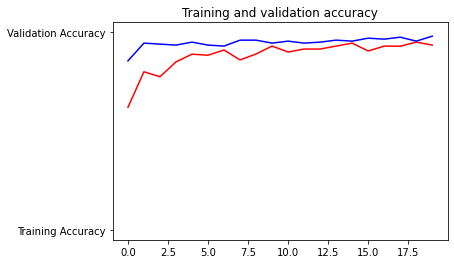

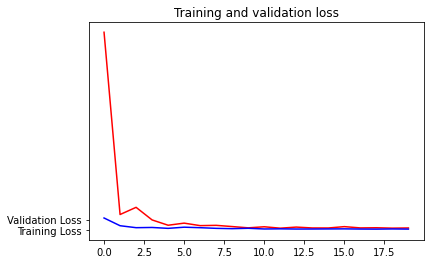

In [ ]:
# Loss and accuracy visualization 

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')


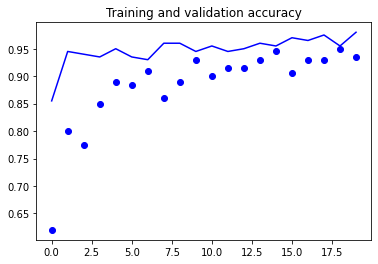

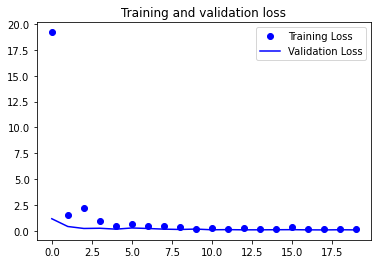

In [ ]:
# Alternative Visualization

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Run test on Test Images Dataset
# We collected Test Images Dataset manually using Google Images
# Test Images Dataset consist of 150 unmasked images and 100 masked images

# Files for testing: https://drive.google.com/drive/folders/1erSza7TlApxdMJoM67qIfSJ5bheerBxf?usp=sharing
test_images = '/content//drive/My Drive/Test Images Final Project/masked'
#test_images = '/content//drive/My Drive/Test Images Final Project/unmasked'

# Test Images Edited, Centered : https://drive.google.com/file/d/1sQoxVUmCXWbIfZQT-lkCVNqMIDJH69Dr/view?usp=sharing
    #test_images = '/content//drive/My Drive/Test Images Centered/masked'
    #test_images = '/content//drive/My Drive/Test Images Centered/unmasked'

count_masked = 0
count_unmasked = 0

for fn in os.listdir(test_images) :  
  # predicting images
  path = os.path.join(test_images, fn)
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = x/255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if classes[0]>0.5:
    count_unmasked+=1
    #print(fn + " is not masked")
  else:
    count_masked+=1
    #print(fn + " is masked")

totalz = count_masked + count_unmasked

# Accuracy on Test Images Dataset manually collected from Google
print("{:.3f}".format( (count_masked/totalz*100) ), "percentage classified as masked")
print("{:.3f}".format( (count_unmasked/totalz*100) ), "percentage classified as not masked")

78.000 percentage classified as masked
22.000 percentage classified as not masked


In [ ]:
# Test by manually uploading File(s)

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  
  x = image.img_to_array(img)
  x = x/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is not masked")
  else:
    print(fn + " is masked")

totalz = count_masked + count_unmasked

In [ ]:
# Install Tensorflowjs to Convert the model
!pip install tensorflowjs

In [ ]:
# Saving the model for download

save_dir = '/content/drive/My Drive/Classroom/BangkitAssignments/Final/'
path_model = save_dir + "model.h5"
path_modeljs = save_dir + "modeljs"
model.save(path_model)


In [ ]:
print(os.listdir(save_dir))


['datasetmfr', 'model.h5']


In [ ]:
# Fine Tuning by Unfreezing Pretrained Model but with Low Learning Rate

pre_trained_model.trainable = True

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate so not overfit
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Train model
historyft = model.fit(
    train_generatorft,
    validation_data = val_generator,
    epochs = 10,
    verbose = 1
)


Epoch 1/10
109/109 [==============================] - 185s 2s/step - loss: 2.2730 - accuracy: 0.8180 - val_loss: 0.1181 - val_accuracy: 0.9451
Epoch 2/10
109/109 [==============================] - 184s 2s/step - loss: 1.2531 - accuracy: 0.8631 - val_loss: 0.1044 - val_accuracy: 0.9524
Epoch 3/10
109/109 [==============================] - 187s 2s/step - loss: 0.7503 - accuracy: 0.9081 - val_loss: 0.0982 - val_accuracy: 0.9487
Epoch 4/10
109/109 [==============================] - 183s 2s/step - loss: 0.3976 - accuracy: 0.9228 - val_loss: 0.0910 - val_accuracy: 0.9560
Epoch 5/10
109/109 [==============================] - 184s 2s/step - loss: 0.4735 - accuracy: 0.9182 - val_loss: 0.0828 - val_accuracy: 0.9560
Epoch 6/10
109/109 [==============================] - 187s 2s/step - loss: 0.3034 - accuracy: 0.9384 - val_loss: 0.0749 - val_accuracy: 0.9560
Epoch 7/10
109/109 [==============================] - 188s 2s/step - loss: 0.2651 - accuracy: 0.9357 - val_loss: 0.0719 - val_accuracy: 0.9560

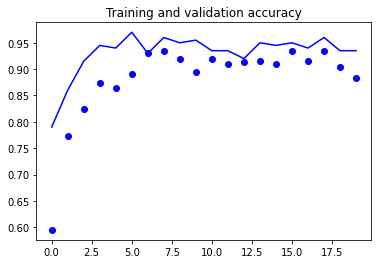

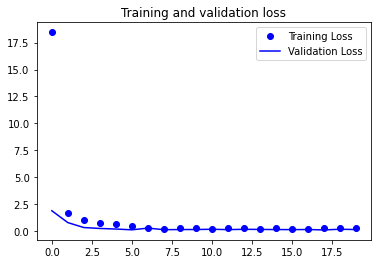

In [ ]:
# Accuracy and Loss Visualization

acc = historyft.history['accuracy']
val_acc = historyft.history['val_accuracy']
loss = historyft.history['loss']
val_loss = historyft.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Run test on Test Images Dataset
# We collected Test Images Dataset manually using Google Images
# Test Images Dataset consist of 150 unmasked images and 100 masked images
# Files for testing: https://drive.google.com/drive/folders/1erSza7TlApxdMJoM67qIfSJ5bheerBxf?usp=sharing

#test_images = '/content//drive/My Drive/Test Images Final Project/masked'
test_images = '/content//drive/My Drive/Test Images Final Project/unmasked'

count_masked = 0
count_unmasked = 0

for fn in os.listdir(test_images) :  
  # predicting images
  path = os.path.join(test_images, fn)
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = x/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if classes[0]>0.5:
    count_unmasked+=1
  else:
    count_masked+=1

totalz = count_masked + count_unmasked

# Accuracy on Test Images Dataset manually collected from Google
print("{:.3f}".format( (count_masked/totalz*100) ), "percentage classified as masked")
print("{:.3f}".format( (count_unmasked/totalz*100) ), "percentage classified as not masked")

22.000 percentage classified as masked
78.000 percentage classified as not masked


In [ ]:
## explore, trial and error OpenCV



In [ ]:
!tensorflowjs_converter --input_format=keras '/content/drive/My Drive/Classroom/BangkitAssignments/Final/model.h5' '/content/drive/My Drive/Classroom/BangkitAssignments/Final/'

usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tfjs_layers_model,tf_saved_model,tf_frozen_model,keras_saved_model,tf_hub,keras}]
                                       [--output_format {keras,tfjs_layers_model,tfjs_graph_model,keras_saved_model}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                                       [--skip_op_check]
                                       [--strip_debug_ops STRIP_DEBUG_OPS]
                                       [-